In [1]:
from spikeforest2_utils import AutoRecordingExtractor, AutoSortingExtractor
import kachery as ka

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

from neurodsp.filt import filter_signal
from neurodsp.timefrequency import phase_by_time
from neurodsp.rhythm import pairwise_phase_consistency
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_power_spectra

from bycycle.spikes.objs import SpikesMEA, Spikes
from bycycle.spikes.features.mea import compute_pca_features

In [2]:
# Configure kachery to download data from the public database
ka.set_config(fr='default_readonly')

# Specify the recording and ground truth sorting
recording_path = 'sha1dir://779d96521176077ec260ef99573dea3b772c74e6.paired_crcns/d11221_d11221.001'
sorting_true_path = 'sha1dir://779d96521176077ec260ef99573dea3b772c74e6.paired_crcns/d11221_d11221.001/firings_true.mda'

recording = AutoRecordingExtractor(recording_path, download=True)
sorting_true = AutoSortingExtractor(sorting_true_path)

In [3]:
fs = 20000

sigs = recording.get_traces()

times = np.arange(0, len(sigs[0])/fs, 1/fs)

# Filter
sig = sigs[0]
del sigs

sig_filt = filter_signal(sig, fs, 'bandpass', (300, 3000), remove_edges=False)

In [4]:
sp = Spikes()

# Extrema/Zero-crossings voltage features
sp.fit(sig_filt, fs, (1000, 2500), n_gaussians=3, std=3,
       tol=1e-2, chunksize=500, progress='tqdm.notebook')

Computing Bycycle Features:   0%|          | 0/9774 [00:00<?, ?it/s]

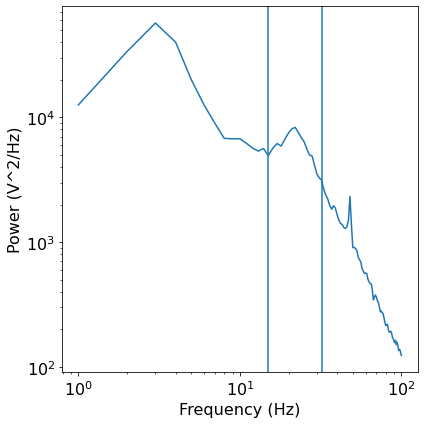

In [5]:
sig_lfp = filter_signal(sig, fs, 'bandpass', (1, 300), remove_edges=False)

f, p = compute_spectrum(sig_lfp, fs, f_range=(1, 100))

plot_power_spectra(f, p)

plt.axvline(15)
plt.axvline(32)

In [6]:
sig_beta = filter_signal(sig, fs, 'bandpass', (15, 32), remove_edges=False)

phase_beta = phase_by_time(sig_beta, fs, None)
phase_sp = phase_by_time(sig_filt, fs, (1000, 2500))

In [7]:
troughs = sp.df_features['sample_trough'].values
phase_beta = phase_beta[troughs]
phase_sp = phase_sp[troughs]

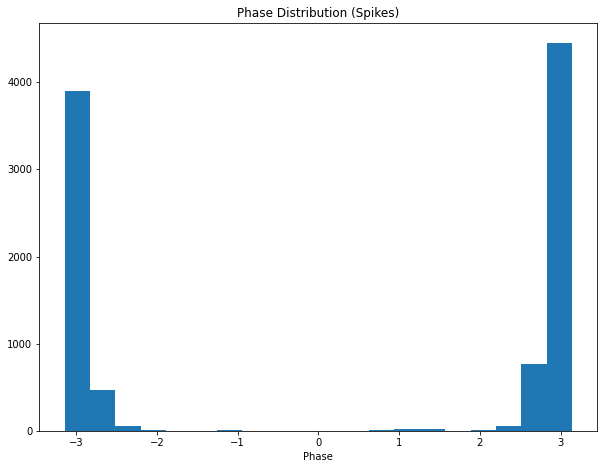

<Figure size 432x288 with 0 Axes>

In [8]:
fig = plt.figure(figsize=(10, 7.5))
plt.hist(phase_sp, bins=20)
plt.title('Phase Distribution (Spikes)')
plt.xlabel('Phase')
plt.show()

plt.savefig('phase_spike.png')

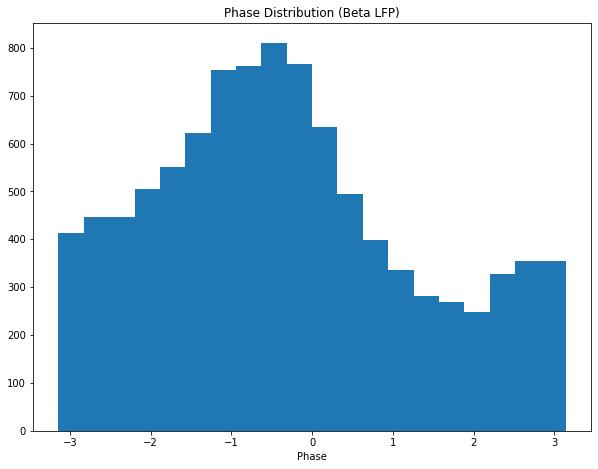

<Figure size 432x288 with 0 Axes>

In [9]:
fig = plt.figure(figsize=(10, 7.5))
plt.hist(phase_beta, bins=20)
plt.title('Phase Distribution (Beta LFP)')
plt.xlabel('Phase')
plt.show()

In [10]:
avg, dist = pairwise_phase_consistency(phase_sp, phase_beta, return_pairs=True, progress='tqdm.notebook')

Computing Pairwise Distances:   0%|          | 0/95531076 [00:00<?, ?it/s]

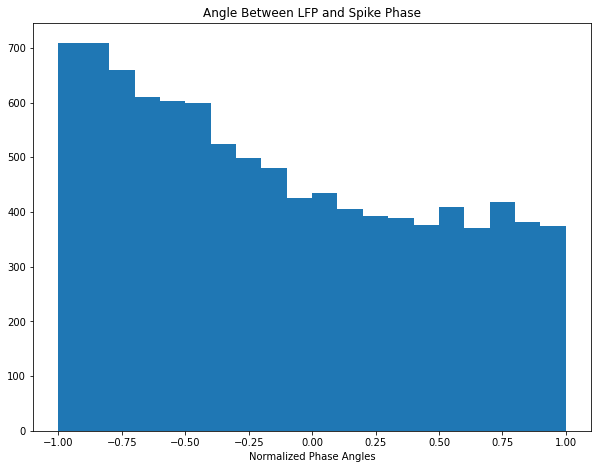

In [11]:
phase_self = np.array([dist[i, i] for i in range(len(phase_sp))])

fig = plt.figure(figsize=(10, 7.5))
plt.hist(phase_self, bins=20)
plt.title('Angle Between LFP and Spike Phase')
plt.xlabel('Normalized Phase Angles')
plt.show()

In [13]:
params = []
corrs = []

for idx, param in enumerate(sp.df_features.columns):
    
    if idx < 18:
        continue
        
    vals = sp.df_features[param].values
    
    phase = phase_self.copy()
    
    if np.isnan(vals).any():
        
        idxs = np.where(np.isnan(vals))[0]
        
        
        _vals = np.delete(vals, idxs)
        _phase = np.delete(phase, idxs)

        corrs.append(np.corrcoef(_vals, _phase)[0][1].round(3))
    else:
        corrs.append(np.corrcoef(vals, phase)[0][1].round(3))
        
    params.append(param)
    
    
df = pd.DataFrame()

df['Param'] = params
df['CorrCoeffs'] = corrs
df

,Param,CorrCoeffs
0,center0,0.088
1,center1,0.074
2,center2,0.106
3,std0,0.025
4,std1,0.087
5,std2,-0.086
6,alpha0,-0.019
7,alpha1,-0.036
8,alpha2,0.006
9,height0,0.079


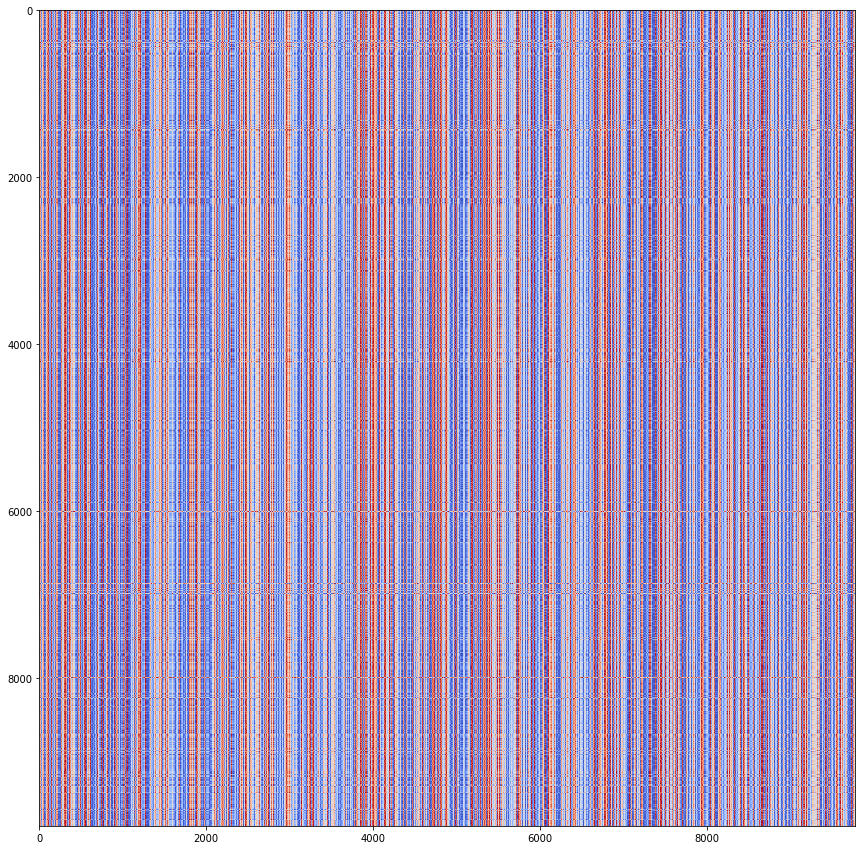

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))

plt.imshow(dist, cmap='coolwarm', interpolation='nearest')
plt.show()

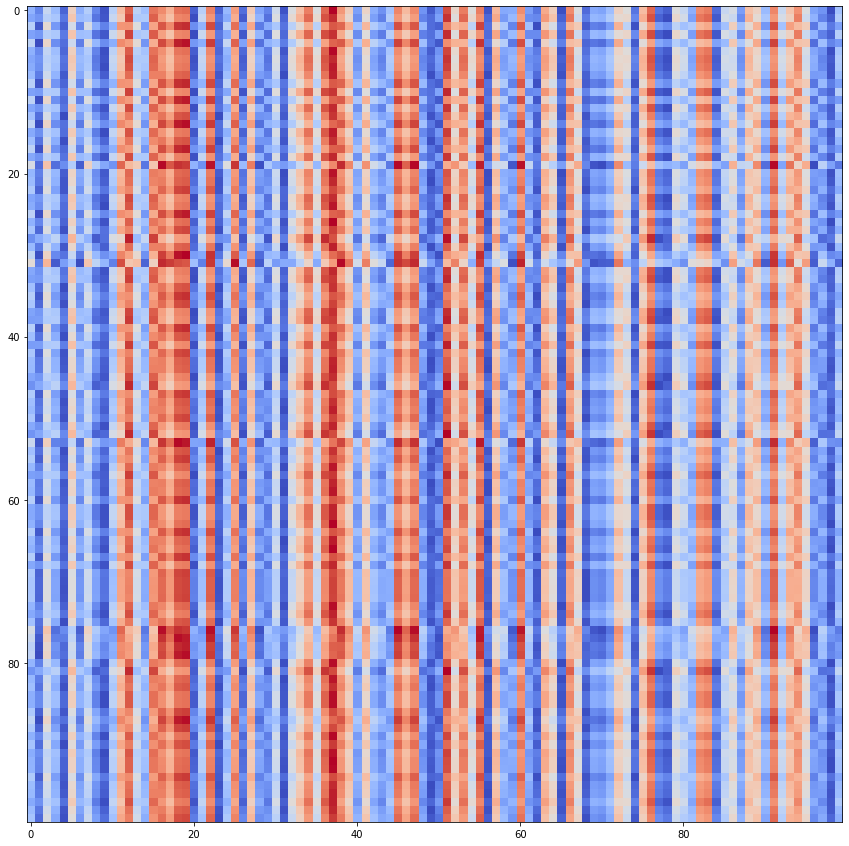

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))

plt.imshow(dist[:100, :100], cmap='coolwarm', interpolation='nearest')
plt.show()

In [16]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from bycycle.spikes.plts import plot_spikes

In [17]:
graph = kneighbors_graph(dist, 100)

aff_mat = .5 * (graph + graph.T)

aff_mat = aff_mat.toarray()

In [18]:
clusts = SpectralClustering(n_clusters=2, affinity='precomputed').fit_predict(aff_mat)

In [19]:
n_clusters = len(np.unique(clusts))

sps = []

for idx in range(n_clusters):    
    sps.append(sp.spikes[np.where(clusts == idx)[0]])

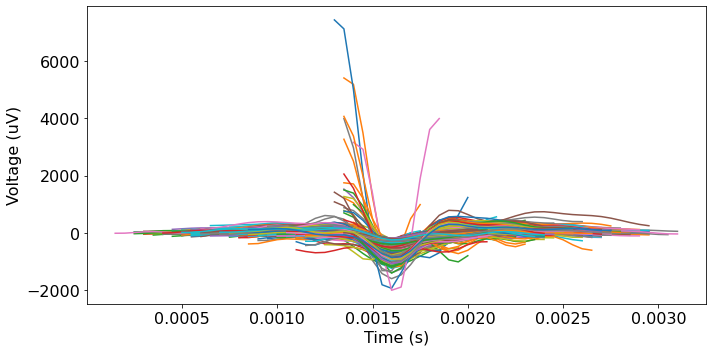

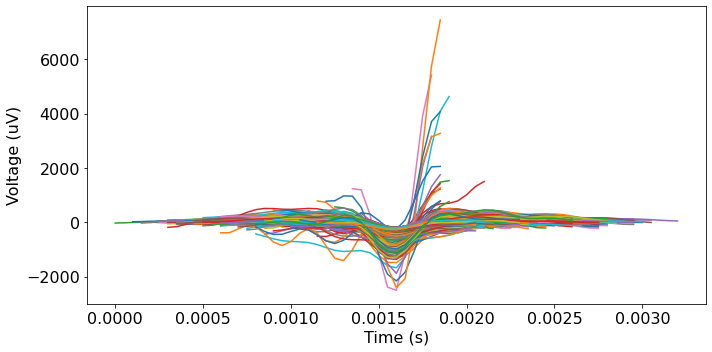

In [20]:
for i in sps:
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    plot_spikes(sp.df_features, sig, fs, spikes=i, ax=ax)

In [21]:
phs = []

for i in range(n_clusters):
    
    idxs = np.where(clusts == i)[0]
    
    phs.append(phase_sp[idxs])

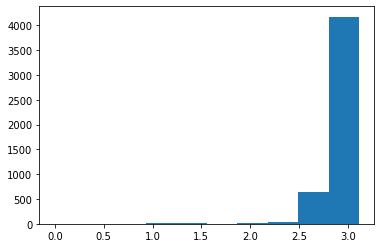

In [22]:
plt.hist(phs[0])
plt.show()

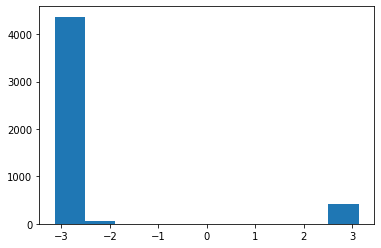

In [23]:
plt.hist(phs[1])
plt.show()

In [25]:
from bycycle import Bycycle

In [27]:
bm = Bycycle()

bm.fit(sig_lfp, fs, (15, 32))

In [39]:
last_troughs = bm.df_features['sample_last_trough']
peaks = bm.df_features['sample_peak']
next_troughs = bm.df_features['sample_next_trough']

locs = np.zeros(len(sig_lfp))
for lt, pk, nt in zip(last_troughs, peaks, next_troughs):
    locs[lt:pk] = 1
    locs[pk:nt] = 2
    
spike_locs = sp.df_features['sample_trough'].values

locs = locs[spike_locs]

In [54]:
rise_spikes = len(np.where(locs == 1)[0])

print('Spikes in LFP Rise: ', rise_spikes, '({x})'.format(x=round(rise_spikes/len(locs), 2)))

decay_spikes = len(np.where(locs == 2)[0])
print('Spikes in LFP Decay: ', decay_spikes, '({x})'.format(x=round(decay_spikes/len(locs), 2)))

Spikes in LFP Rise:  6689 (0.68)
Spikes in LFP Decay:  3084 (0.32)
